# Data Science and Modelling

## Hypothesis Testing

### Model Fitting - Not in notes, an outline of the process from chapter 5

#### Good Example

In [595]:
import numpy as np
from scipy import stats

true_mean = 2.6

data = stats.poisson(2.6).rvs(size=50)
# PRETEND WE DONT SEE THIS - WE'VE JUST BEEN HANDED A DATA FILE

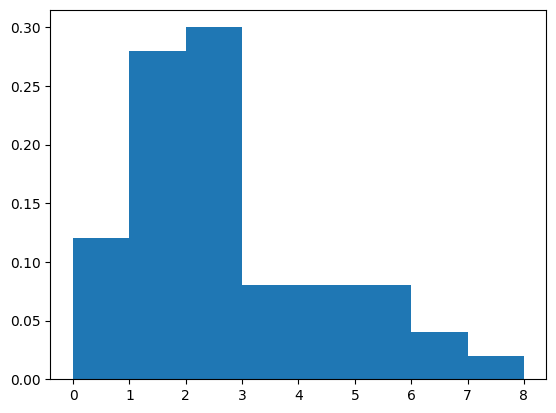

In [596]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

bins = ax.hist(data, bins=8, range=(0, 8), density=True)

In [597]:
n_theta = 200

theta_lims = (1, 6)

theta = np.linspace(theta_lims[0], theta_lims[1], n_theta)

#### Bayesian

Step 1: We propose a prior - an informed guess of where we think the optimal parameters may be

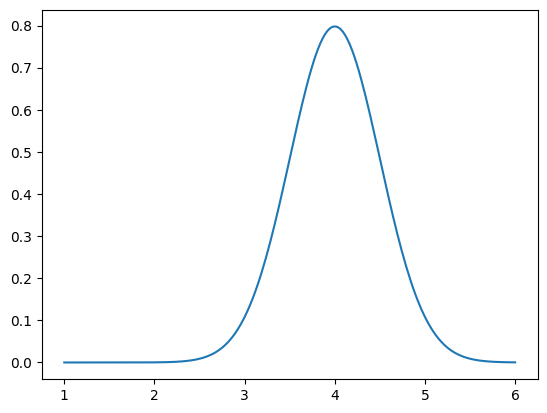

In [598]:
def prior(theta):
    return stats.norm.pdf(theta, loc=4, scale=0.5)


fig, ax = plt.subplots()
ax.plot(theta, prior(theta))

In [599]:
def log_likelihood(theta, data):
    n = len(data)
    t = sum(data)
    return -n * theta + t * np.log(theta)


def log_prior(theta):
    return np.log(prior(theta))


def log_posterior(theta, data):
    return log_likelihood(theta, data) + log_prior(theta)


prior_res = np.exp(log_prior(theta))
prior_res /= np.sum(prior_res)

likelihood_res = np.exp(log_likelihood(theta, data))
likelihood_res /= np.sum(likelihood_res)

posterior_res = np.exp(log_posterior(theta, data))
posterior_res /= np.sum(posterior_res)

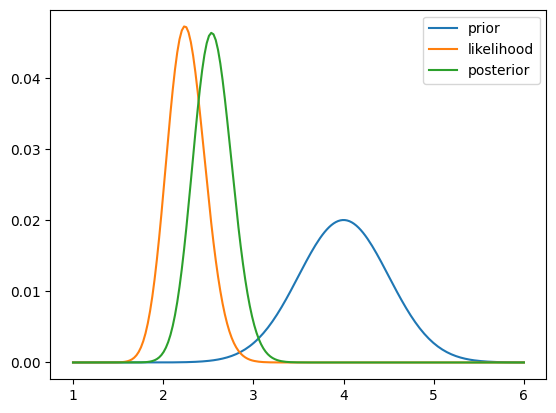

In [600]:
fig, ax = plt.subplots()
ax.plot(theta, prior_res, label="prior")
ax.plot(theta, likelihood_res, label="likelihood")
ax.plot(theta, posterior_res, label="posterior")
ax.legend()

Our resultant posterior: our PDF for the location of the distribution mean

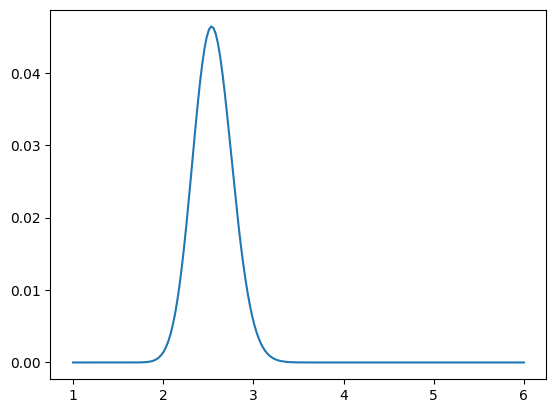

In [601]:
fig, ax = plt.subplots()

ax.plot(theta, posterior_res)

Construct the credible interval at a 95% confidence level:

The credible interval at a 99.70% confidence level is [1.93, 3.21]
We are 99.70% sure the mean is between 1.93 and 3.21.


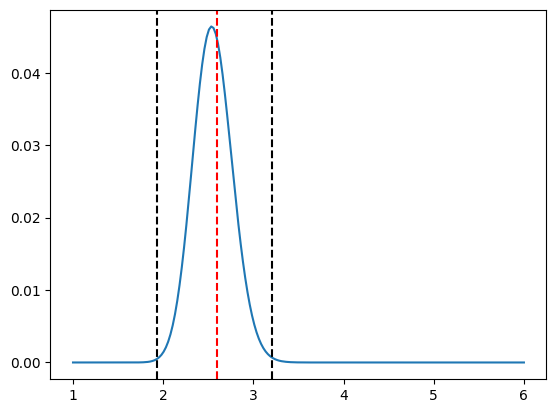

In [602]:
from scipy.optimize import bisect
from scipy import integrate

CL = 0.997
q = (1 - CL) / 2

integrals = np.cumulative_sum(posterior_res)

lower_limit = theta[np.argmin(np.abs(integrals - q))]
upper_limit = theta[np.argmin(np.abs(integrals - (1 - q)))]

print(
    f"The credible interval at a {CL*100:.2f}% confidence level is [{lower_limit:.2f}, {upper_limit:.2f}]"
)
print(
    f"We are {100*CL:.2f}% sure the mean is between {lower_limit:.2f} and {upper_limit:.2f}."
)

fig, ax = plt.subplots()
ax.plot(theta, posterior_res)
ax.axvline(lower_limit, linestyle="--", color="k")
ax.axvline(upper_limit, linestyle="--", color="k")
ax.axvline(true_mean, linestyle="--", color="r")

#### Frequentist

In [603]:
def log_likelihood(theta, data):
    n = len(data)
    t = sum(data)
    return -n * theta + t * np.log(theta)


likelihood_res = np.exp(log_likelihood(theta, data))
likelihood_res /= np.sum(likelihood_res)

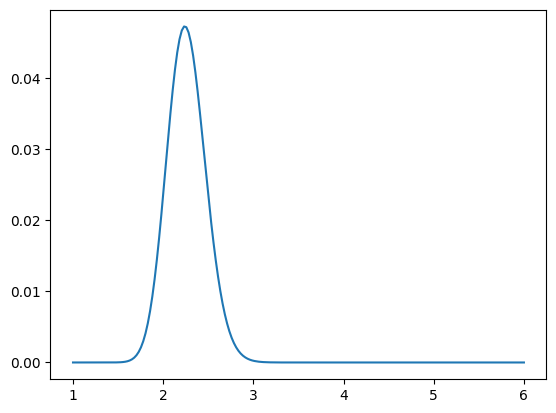

In [604]:
fig, ax = plt.subplots()
ax.plot(theta, likelihood_res)

[2.23999995]


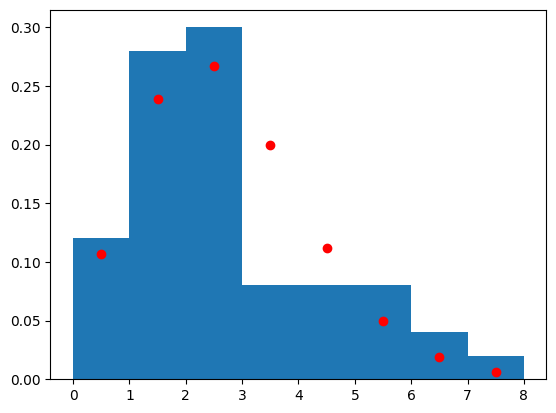

In [605]:
from scipy import optimize as opt


def minus_log_likelihood(theta):
    return -log_likelihood(theta, data)


optimal = opt.differential_evolution(
    minus_log_likelihood,
    bounds=[
        (1, 4),
    ],
)

print(optimal.x)

fig, ax = plt.subplots()

x = np.array(range(8))

ax.hist(data, bins=8, density=True, range=(0, 8))
ax.scatter(x + 0.5, stats.poisson(optimal.x).pmf(x), color="r")

Construct a confidence interval using Bootstrap Resampling

In [606]:
Nboot = 200

bootstrap_resample = np.empty((200, len(data)))

np.random.seed(8)
for i in range(Nboot):
    bootstrap_resample[i] = np.random.choice(data, len(data), replace=True)

In [607]:
result = np.empty(Nboot)
for i in range(Nboot):
    minus_log_likelihood_resample = lambda x: -log_likelihood(x, bootstrap_resample[i])
    optimal = opt.differential_evolution(minus_log_likelihood_resample, bounds=[(1, 4)])
    result[i] = optimal.x[0]

Use the bootstrap derived sampling distribution to define the 95% confidence interval of the model parameter (i.e., where we are 95% confident the parameter lies based on the observed distribution) 

In [612]:
CL = 0.95

lower_limit = np.mean(result) - 2 * np.std(result)
upper_limit = np.mean(result) + 2 * np.std(result)

print(
    f"The confidence interval at a {CL*100:.2f}% confidence level is [{lower_limit:.2f}, {upper_limit:.2f}]"
)
print(
    f"I.e., we are {100*CL:.2f}% sure the population mean is between {lower_limit:.2f} and {upper_limit:.2f}."
)

print(f"The true population mean was {true_mean:.2f}.")

The confidence interval at a 95.00% confidence level is [1.76, 2.76]
I.e., we are 95.00% sure the population mean is between 1.76 and 2.76.
The true population mean was 2.60.


#### Bad Example

In [613]:
import numpy as np
from scipy import stats

# data=np.random.choice(np.concatenate([stats.norm.rvs(scale=0.1,size=1000),stats.norm.rvs(loc=1,scale=0.1,size=1000)],axis=0),1000)
data = stats.expon.rvs(size=1000)
data = data[data < 4]

# data = stats.norm.rvs(size=10000)

(array([0.81170566, 0.60814312, 0.36386806, 0.23664146, 0.1755727 ,
        0.10941487, 0.08396955, 0.04325704, 0.03816798, 0.03053438]),
 array([4.10878703e-04, 4.00207011e-01, 8.00003143e-01, 1.19979928e+00,
        1.59959541e+00, 1.99939154e+00, 2.39918767e+00, 2.79898381e+00,
        3.19877994e+00, 3.59857607e+00, 3.99837220e+00]),
 <BarContainer object of 10 artists>)

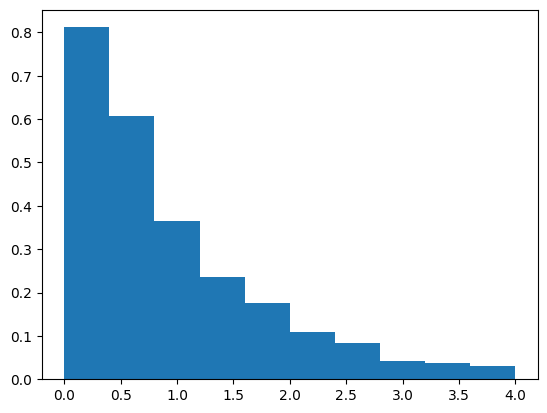

In [614]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(data, bins=10, density=True)

This looks like a Gaussian to me... (or does it...?)

Let's find the model that fits!

In [615]:
def loglikelihood(theta, data):
    n = len(data)
    return (
        -(n / 2) * np.log(2 * np.pi)
        - (n) * np.log(theta[1])
        - np.sum((data - theta[0]) ** 2) / (2 * theta[1] ** 2)
    )
    # return np.sum(np.log(stats.norm(*theta).pdf(data)))


n_mu = 50
n_sigma = 50

mu_lims = (0.7, 1.2)
sigma_lims = (0.7, 0.9)

mu = np.linspace(mu_lims[0], mu_lims[1], n_mu)
sigma = np.linspace(sigma_lims[0], sigma_lims[1], n_sigma)

Mu, Sigma = np.meshgrid(mu, sigma)

theta = np.empty((2, n_mu, n_sigma))
theta[0] = Mu
theta[1] = Sigma

result = np.empty_like(Mu)
for i in range(n_mu):
    for j in range(n_sigma):
        result[i, j] = loglikelihood(theta[:, i, j], data)


result -= np.max(result)
result = np.exp(result)

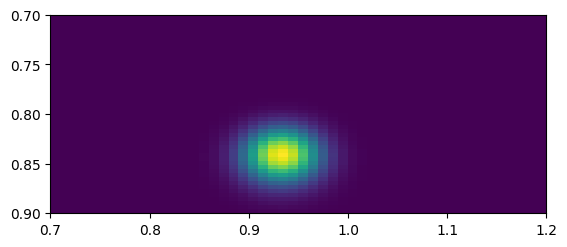

In [616]:
fig, ax = plt.subplots()
ax.imshow(result, extent=[mu_lims[0], mu_lims[1], sigma_lims[1], sigma_lims[0]])

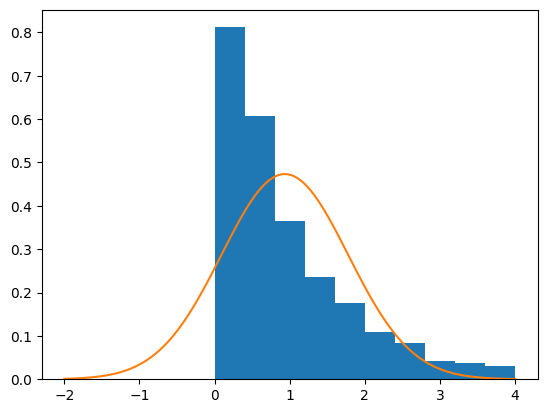

In [617]:
top_ind = np.unravel_index(np.argmax(result), result.shape)
top_theta = theta[:, top_ind[0], top_ind[1]]

fig, ax = plt.subplots()

x = np.linspace(-2, 4, 100)

ax.hist(data, bins=10, density=True)
ax.plot(x, stats.norm(*top_theta).pdf(x))

This is the normal distribution that "best" models this data...

There will always exist a set of parameters for a given model and dataset that "maximise" the likelihood, and hence denote the parameters with the highest probability of correctly describing the data.

But if the model is not the correct model, these "best" parameters will still be poor descriptors of the data.

## Frequentist Hypothesis Testing

##### Exercise 6.1

We are evaluating $$\sum_{i=78}^{100}\mathcal{P}(i;100,0.5)+\sum_{i=0}^{22}\mathcal{P}(i;100,0.5)$$

In [618]:
from scipy import stats

dist = stats.binom(100, 0.5)

P = np.sum(np.array([dist.pmf(i) for i in range(78, 101)])) + np.sum(
    np.array([dist.pmf(i) for i in range(0, 23)])
)
print(f"Probability of observing <=22 or >=78 heads given null hypothesis: {P:.3g}")

Probability of observing <=22 or >=78 heads given null hypothesis: 1.59e-08


In [619]:
stats.binomtest(78, 100, 0.5).pvalue

np.float64(1.5905328473786136e-08)

##### Exercise 6.2

In [620]:
def coin_test(H):
    P = stats.binomtest(H, 100, 0.5).pvalue
    if P < (1 - 0.95):
        print(f"Null hypothesis is     rejected at 95% CL with {H = }, with {P = :.3g}")
    else:
        print(f"Null hypothesis is not rejected at 95% CL with {H = }, with {P = :.3g}")


coin_test(78)
coin_test(60)

Null hypothesis is     rejected at 95% CL with H = 78, with P = 1.59e-08
Null hypothesis is not rejected at 95% CL with H = 60, with P = 0.0569


### Chi2 Test

In [621]:
import numpy as np

data = np.loadtxt("cr_data.txt")
hour = data[:, 0]
rate = data[:, 1]
sigma = data[:, 2]

Text(0, 0.5, 'Corrected Muon Rate (Hz)')

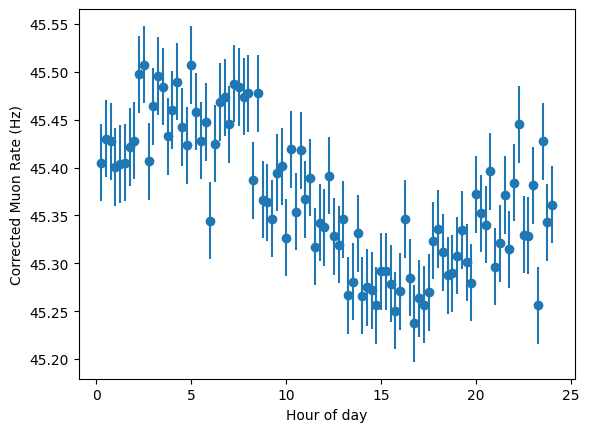

In [622]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.errorbar(hour, rate, yerr=sigma, fmt="o")

ax.set_xlabel("Hour of day")
ax.set_ylabel("Corrected Muon Rate (Hz)")

Our ansatz:
$$ R = \overline{R} + A\sin\left(\frac{2\pi(t-t_0)}{24}\right)$$

We will assume $(\overline{R},A,t_0)=(45.35,0.1,-1)$.

In [623]:
Rbar = 45.35
A = 0.1
tzero = -1.0

expected_rate = Rbar + A * np.sin(2 * np.pi * (hour - tzero) / 24)

Text(0, 0.5, 'Corrected Muon Rate (Hz)')

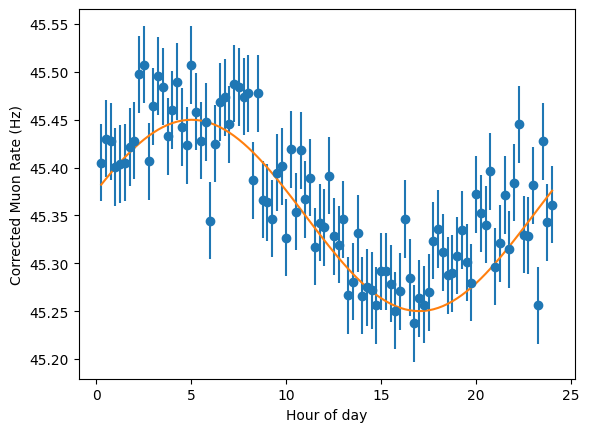

In [624]:
fig, ax = plt.subplots()

ax.errorbar(hour, rate, yerr=sigma, fmt="o")
ax.plot(hour, expected_rate)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Corrected Muon Rate (Hz)")

In [625]:
chi_squared = ((rate - expected_rate) ** 2 / sigma**2).sum()
print(f"Chi squared = {chi_squared:.1f}")

Chi squared = 115.1


In [626]:
crit = stats.chi2.ppf(q=0.95, df=96)
print(f"Chi squared critical value = {crit:.1f}")

Chi squared critical value = 119.9


The model $\chi^2$ is less than the critical value at the 95% CL, therefore our model is compatible with the data at this confidence level.

In [627]:
crit = stats.chi2.ppf(q=0.68, df=96)
print(f"Chi squared critical value at 68% CL = {crit:.1f}")

Chi squared critical value at 68% CL = 101.9


Our model is **not** compatible with the data at the 68% CL. At the 68% CL, we can reject this as the correct model for this data.

In [628]:
def chi_squared(params):
    Rbar, A, tzero = params
    expected_rate = Rbar + A * np.sin(2 * np.pi * (hour - tzero) / 24)
    chisq = ((rate - expected_rate) ** 2 / sigma**2).sum()
    return chisq

In [629]:
import scipy.optimize as opt

fit = opt.minimize(
    chi_squared, x0=(45.35, 0.1, -1), bounds=[(45.2, 45.6), (0, 0.2), (-2, 0)]
)

Rbar_fit, A_fit, tzero_fit = fit.x
expected_rate_fit = Rbar_fit + A_fit * np.sin(2 * np.pi * (hour - tzero_fit) / 24)

In [630]:
chi_squared_fit = ((rate - expected_rate_fit) ** 2 / sigma**2).sum()
print(f"Chi squared = {chi_squared_fit:.1f}")

Chi squared = 85.2


As we have fit 3 parameters, we have lost 3 effective degrees of freedom. Hence $$\mathrm{df}=96-3=93.$$

In [631]:
crit = stats.chi2.ppf(q=0.68, df=93)
print(f"Chi squared critical value at 68% CL = {crit:.1f}")

Chi squared critical value at 68% CL = 98.8


In [632]:
crit = stats.chi2.ppf(q=0.997, df=93)
print(f"Chi squared critical value at 99.7% CL = {crit:.1f}")

Chi squared critical value at 99.7% CL = 134.8


Our new fitted model is compatible with the data at the 68% confidence level.

Text(0, 0.5, 'Corrected Muon Rate (Hz)')

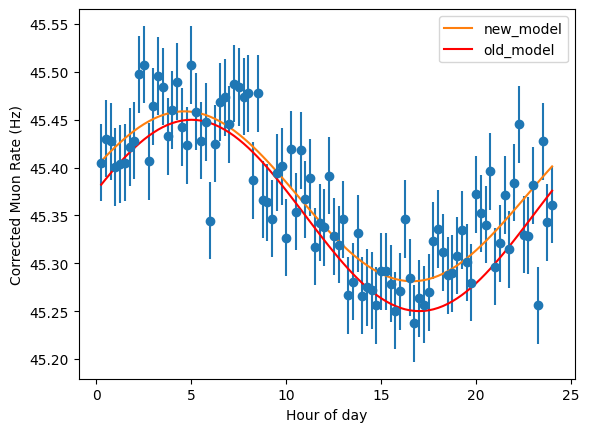

In [633]:
fig, ax = plt.subplots()

ax.errorbar(hour, rate, yerr=sigma, fmt="o")
ax.plot(hour, expected_rate_fit, label="new_model")
ax.plot(hour, expected_rate, color="r", label="old_model")
ax.legend()
ax.set_xlabel("Hour of day")
ax.set_ylabel("Corrected Muon Rate (Hz)")

### Chi 2 Distribution

Let's pretend: We've gone and "measured" muon counts in a given hour, at 3 hour intervals (12am, 3am, 6am, ...) on each day. We do this for 1000 days. The plot below is what we "measured" on certain days.

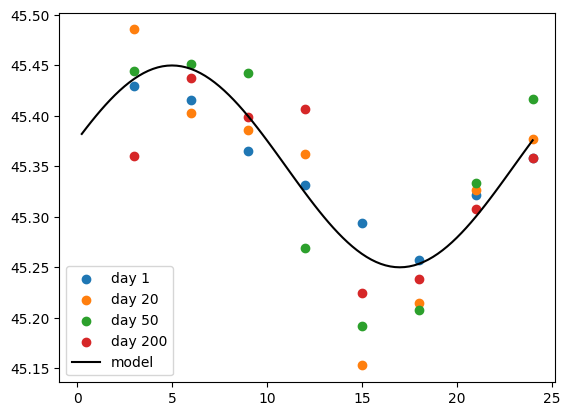

In [ ]:
n_experiments = 1000
std_dev = sigma[0]

hours_exp = np.array([3, 6, 9, 12, 15, 18, 21, 24])

data = np.empty((n_experiments, len(hours_exp)))
for i in range(n_experiments):
    data[i] = (
        Rbar
        + A * np.sin(2 * np.pi * (hours_exp - tzero) / 24)
        + stats.norm(0, std_dev).rvs(len(hours_exp))
    )

fig, ax = plt.subplots()
ax.scatter(hours_exp, data[1], label="day 1")
ax.scatter(hours_exp, data[20], label="day 20")
ax.scatter(hours_exp, data[50], label="day 50")
ax.scatter(hours_exp, data[200], label="day 200")
ax.plot(hour, Rbar + A * np.sin(2 * np.pi * (hour - tzero) / 24), c="k", label="model")
ax.legend()

Calculate $\chi^2$ for each experiment (day). Compare to the $\chi^2$ distribution for $\mathrm{df}=96$:

Text(0.5, 0, '$\\chi^2$')

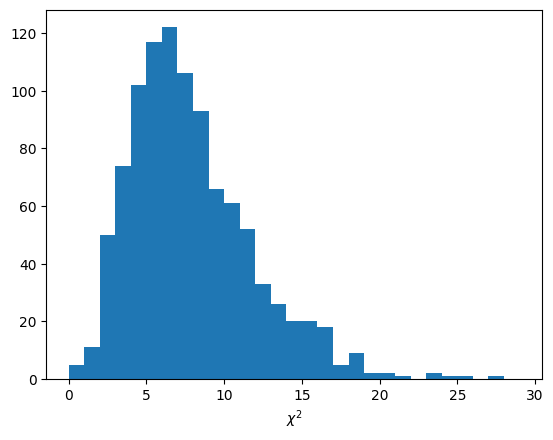

In [ ]:
def chi_squared_experiments(data):
    expected_rate = Rbar + A * np.sin(2 * np.pi * (hours_exp - tzero) / 24)
    chisq = ((data - expected_rate) ** 2 / std_dev**2).sum()
    return chisq


res = np.empty((n_experiments))
for i in range(n_experiments):
    res[i] = chi_squared_experiments(data[i])


x = np.linspace(0, 20)

fig, ax = plt.subplots()
ax.hist(res, density=False, bins=np.arange(30))
# ax.plot(x, stats.chi2.pdf(x, df=len(hours_exp)), label=r"$\chi^2$ dist: "+f"df={len(hours_exp)}")
ax.set_xlabel(r"$\chi^2$")
# ax.legend()

We will plot this histogram along with the $\chi^2$ distribution for 8 degrees of freedom.

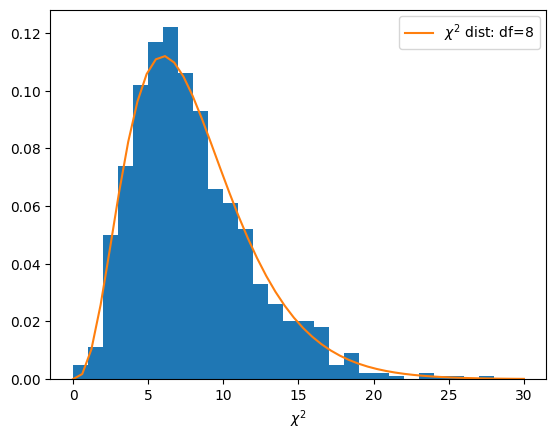

In [ ]:
def chi_squared_experiments(data):
    expected_rate = Rbar + A * np.sin(2 * np.pi * (hours_exp - tzero) / 24)
    chisq = ((data - expected_rate) ** 2 / std_dev**2).sum()
    return chisq


res = np.empty((n_experiments))
for i in range(n_experiments):
    res[i] = chi_squared_experiments(data[i])


x = np.linspace(0, 30)

fig, ax = plt.subplots()
ax.hist(res, density=True, bins=np.arange(30))
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp)),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)}",
)
ax.set_xlabel(r"$\chi^2$")
ax.legend()

If the null hypothesis is correct, the $\chi^2$ calculated for a given dataset against the null hypothesis model should follow the $\chi^2$ distribution for $\mathrm{df}$ equal to the number of data points. This plot agrees with that fact, showing the null hypothesis (the model) appears to be correct!

In [637]:
crit = stats.chi2.ppf(q=0.997, df=8)
print(f"Chi squared critical value at 99.7% CL = {crit:.1f}")

Chi squared critical value at 99.7% CL = 23.3


If we collected a dataset and calculated a $chi^2$ above the critical value, we have sufficient evidence to reject the null hypothesis (the model) at the given confidence level.

What if we refit the model for each dataset? How should the $\chi^2$ vary in this case?

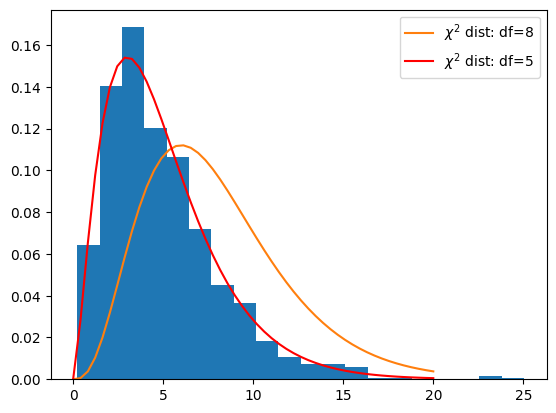

In [ ]:
def chi_squared_experiments_ansatz(params, data):
    Rbar_i = params[0]
    A_i = params[1]
    tzero_i = params[2]

    expected_rate = Rbar_i + A_i * np.sin(2 * np.pi * (hours_exp - tzero_i) / 24)
    chisq = ((data - expected_rate) ** 2 / std_dev**2).sum()
    return chisq


res = np.empty((n_experiments))
for i in range(n_experiments):

    fit = opt.minimize(
        chi_squared_experiments_ansatz,
        args=(data[i]),
        x0=(45.35, 0.1, -1),
        bounds=[(45.2, 45.6), (0, 0.2), (-2, 0)],
    )

    res[i] = chi_squared_experiments_ansatz(fit.x, data[i])

x = np.linspace(0, 20)

fig, ax = plt.subplots()
ax.hist(res, density=True, bins=20)
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp)),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)}",
)
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp) - 3),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)-3}",
    c="red",
)
ax.legend()

Now it looks like the $\chi^2$ is not following the distribution with $\mathrm{df}$ equal to the number of data points, but instead the distribution with $\mathrm{df}$ equal to **three** less than the number of data points. What is the connection? Maybe look at the model we are fitting each sample, and where **three** might emerge from?

What if we only let one parameter vary between each sample? Let's only vary the average $\overline{R}$

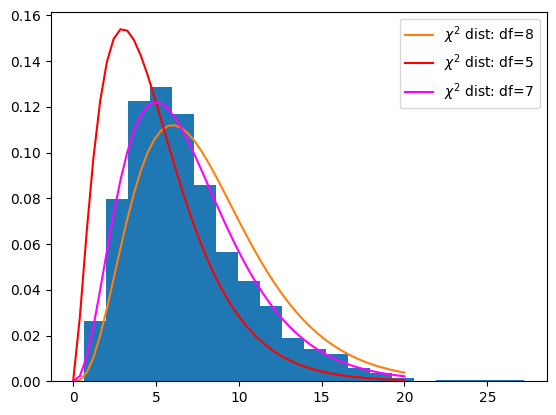

In [ ]:
def chi_squared_experiments_ansatz_R(params, data):
    Rbar_i = params[0]

    expected_rate = Rbar_i + A * np.sin(2 * np.pi * (hours_exp - tzero) / 24)
    chisq = ((data - expected_rate) ** 2 / std_dev**2).sum()
    return chisq


res = np.empty((n_experiments))
for i in range(n_experiments):

    fit = opt.minimize(
        chi_squared_experiments_ansatz_R,
        args=(data[i]),
        x0=(45.35,),
        bounds=[
            (45.2, 45.6),
        ],
    )

    res[i] = chi_squared_experiments_ansatz_R(fit.x, data[i])

x = np.linspace(0, 20)

fig, ax = plt.subplots()
ax.hist(res, density=True, bins=20)
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp)),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)}",
)
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp) - 3),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)-3}",
    c="red",
)
ax.plot(
    x,
    stats.chi2.pdf(x, df=len(hours_exp) - 1),
    label=r"$\chi^2$ dist: " + f"df={len(hours_exp)-1}",
    c="magenta",
)
ax.legend()

Now it's following the $\chi^2$ distribution with $\mathrm{df}$ equal to **one** less than the number of data points! 

If it's not immediately obvious, $\mathrm{df}$ should be equal to the number of data points, *minus the number of free parameters in the model* between each sample. In the first case, the model was frozen, hence no free parameters. In the seconds, we were allowing all **three** parameters to vary between samples, while in the third, only **one** parameter could vary. Hence we expect, if the null hypothesis is correct, the $\chi^2$ calculated on each sample to follow the $\chi^2$ distribution for $$\mathrm{df}=N_{\mathrm{data}} - N_{\mathrm{params}},$$ for $N_{\mathrm{data}}$ the number of data points in the sample and $N_{\mathrm{params}}$ the number of free parameters varying in the model between samples. 

### Comparing Hypotheses

##### Exercise 6.7

As an example. The numbers here may not represent actual cosmology:

There are two supernovae in the sky producing cosmic rays in our atmosphere. One of these supernovae produce on average 3 cosmic rays per second, while the other produces 7 cosmic rays per second, both in bursts of 10 seconds. We place our cosmic ray detector on the roof and wait for a burst. We see one, and it looks like this:

(rerun the below cell for different bursts)

(array([1., 1., 3., 4., 1.]),
 array([ 2. ,  3.6,  5.2,  6.8,  8.4, 10. ]),
 <BarContainer object of 5 artists>)

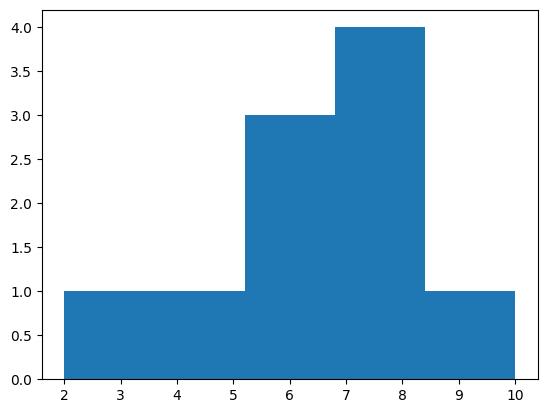

In [642]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

n = 10
lambda0 = 3
lambda1 = 7


p = np.random.rand()
if p >= 0.5:
    data = poisson.rvs(lambda0, size=n)
else:
    data = poisson.rvs(lambda1, size=n)

fig, ax = plt.subplots()
ax.hist(data, bins=5)

Which of the two supernovae did this burst come from? Depending on what you see it may or may not be clear, but with the low available stats it's hard to be sure. So, we test the LLR. We will refer to the distribution of the supernova with a mean rate of 3 as the "background hypothesis" $\mathcal{H}_0$, while the supernova with a mean rate of 7 will be the "signal hypothesis" $\mathcal{H}_1$ (this is just a convention for now):

In [ ]:
def llr(lambda0, lambda1, data):
    n = len(data)
    Xbar = np.mean(data)
    result = -2 * n * (Xbar * np.log(lambda1 / lambda0) + lambda0 - lambda1)
    return result


ratio = llr(lambda0, lambda1, data)
print(
    f"The log likelihood ratio between the two supernovae hypotheses of the observed data is {ratio:.2f}"
)

The log likelihood ratio between the two supernovae hypotheses of the observed data is -31.84


Remember: a negative value is more "background-like", meaning $\mathcal{H}_0$ is more likely (in our case the supernova with a mean rate of 3), while a positive value is more "signal-like" indicating $\mathcal{H}_1$ (the distribution with a mean of 7).

Let's run this 20000 times, where let's say the two supernovae alternate bursts, and plot the distribution of LLRs

In [ ]:
res = np.empty(200000)
for i in range(100000):
    data = poisson.rvs(lambda0, size=n)
    res[2 * i] = llr(lambda0, lambda1, data)

    data = poisson.rvs(lambda1, size=n)
    res[2 * i + 1] = llr(lambda0, lambda1, data)

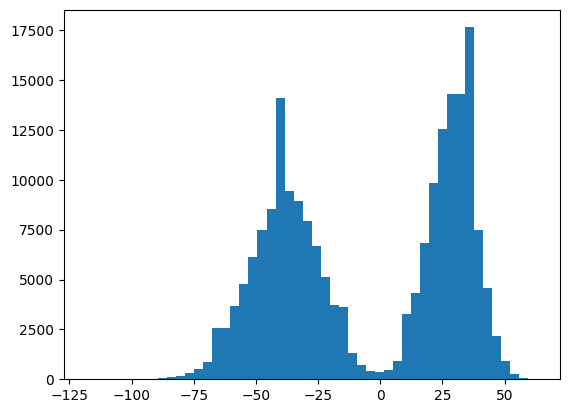

In [ ]:
fig, ax = plt.subplots()
bins = ax.hist(res, bins=50)

We observe a bimodal distribution of LLRs. The events in the negative mode are more likely to have originated from the "signal hypothesis" $\mathcal{H}_1$, while those in the positive mode likely came from the "background hypothesis" $\mathcal{H}_0$. 

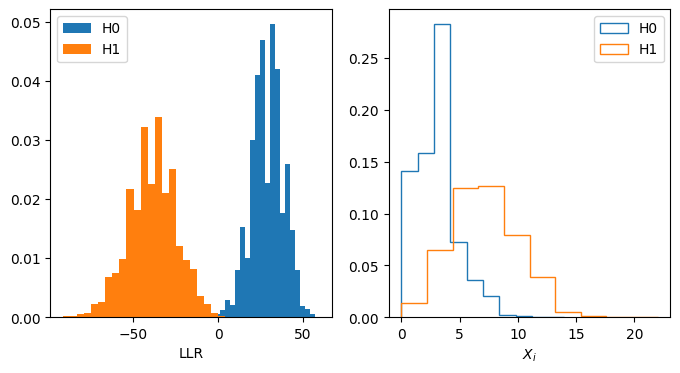

In [ ]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt


def llr(lambda0, lambda1, Xbar, n):
    result = -2 * n * (Xbar * np.log(lambda1 / lambda0) + lambda0 - lambda1)
    return result


num_experiments = 10000
n = 10
lambda0 = 3
lambda1 = 7
llr_dist_0 = np.zeros(num_experiments)
llr_dist_1 = np.zeros(num_experiments)
XDist0 = np.empty((num_experiments, n))
XDist1 = np.empty((num_experiments, n))

for experiment in range(num_experiments):
    X0 = poisson.rvs(lambda0, size=n)
    XDist0[experiment, :] = X0
    X1 = poisson.rvs(lambda1, size=n)
    XDist1[experiment, :] = X1
    llr_dist_0[experiment] = llr(lambda0, lambda1, X0.sum() / n, n)
    llr_dist_1[experiment] = llr(lambda0, lambda1, X1.sum() / n, n)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
myHist0 = ax[0].hist(llr_dist_0, label="H0", density=True, bins=25)
myHist1 = ax[0].hist(llr_dist_1, label="H1", density=True, bins=25)
ax[0].legend()
ax[0].set_xlabel("LLR")

myHist0 = ax[1].hist(XDist0.flatten(), label="H0", density=True, histtype="step")
myHist1 = ax[1].hist(XDist1.flatten(), label="H1", density=True, histtype="step")
ax[1].legend()
ax[1].set_xlabel("$X_i$")

x = np.linspace(0, 500)

If we actually keep track of where each event came from and colour the resultant histograms, this shows much more clearly the discriminability between the two hypotheses.

The plot on the right shows the actual histograms of counts from each of the events per second. As we can see, the two overlap significantly, showing it is difficult to tell which of the hypotheses a single datapoint originated from. 

##### Exercise 6.8

Text(0.5, 0, '$X_i$')

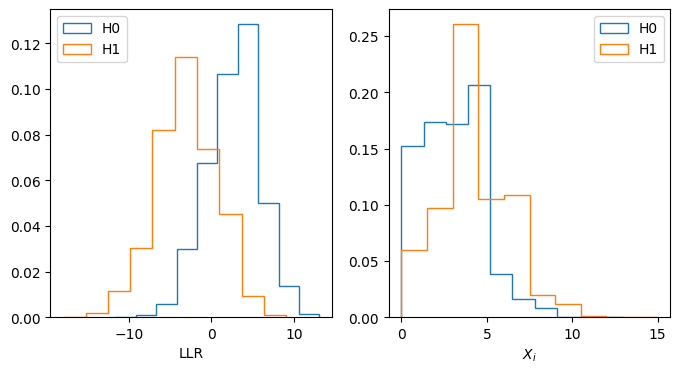

In [650]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt


def llr(lambda0, lambda1, Xbar, n):
    result = -2 * n * (Xbar * np.log(lambda1 / lambda0) + lambda0 - lambda1)
    return result


num_experiments = 10000
n = 10
lambda0 = 3
lambda1 = 4
llr_dist_0 = np.zeros(num_experiments)
llr_dist_1 = np.zeros(num_experiments)
XDist0 = np.empty((num_experiments, n))
XDist1 = np.empty((num_experiments, n))

for experiment in range(num_experiments):
    X0 = poisson.rvs(lambda0, size=n)
    XDist0[experiment, :] = X0
    X1 = poisson.rvs(lambda1, size=n)
    XDist1[experiment, :] = X1
    llr_dist_0[experiment] = llr(lambda0, lambda1, X0.sum() / n, n)
    llr_dist_1[experiment] = llr(lambda0, lambda1, X1.sum() / n, n)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
myHist0 = ax[0].hist(llr_dist_0, label="H0", density=True, histtype="step")
myHist1 = ax[0].hist(llr_dist_1, label="H1", density=True, histtype="step")
ax[0].legend()
ax[0].set_xlabel("LLR")

myHist0 = ax[1].hist(XDist0.flatten(), label="H0", density=True, histtype="step")
myHist1 = ax[1].hist(XDist1.flatten(), label="H1", density=True, histtype="step")
ax[1].legend()
ax[1].set_xlabel("$X_i$")

In this case the hypothesis test is much less conclusive, as shown in the plot on the left. A significant number of tests where the new hypothesis is correct result in a positive log-likelihood, and vice versa. Due to this while the log-likelihood still has discriminatory power, this power has been significantly diminished.

As shown in the plot on the right, the two distributions now look far more similar compared to before, showing why distinguishing between the two has become more difficult.

### Likelihood Profiling

##### Exercise 6.9

With a PDF given by $$p(x_i;\lambda) = \frac{\lambda^{x_i}e^{-\lambda}}{x_i!},$$
the log-likelihood is given by $$\ln(\mathcal{L}(\lambda))=\ln(\prod_i p(x_i;\lambda))=\sum_i \ln(p_i;\lambda) $$ $$= \sum_i (x_i \ln(\lambda) - \lambda - \ln(x_i!))$$ $$= n\overline{x}\ln(\lambda) - n\lambda - \sum_i\ln(x_i!),$$ where we know that $\sum_i x_i  = n\overline{x}$ for $\overline{x}$ the mean, and $n$ the total number of points.

To find the value of $\lambda$ that maximises the log-likelihood, denoted $\widehat\lambda$, we find a stationary point in the log-likelihood: $$\frac{\mathrm{d}}{\mathrm{d}\lambda} \ln(\mathcal{L}(\lambda)) = \frac{n\overline{x}}{\lambda} - n$$ $$\implies \frac{n\overline{x}}{\widehat{\lambda}} - n =0$$
$$\implies \widehat{\lambda} = \overline{x}.$$

Our log-likelihood profile is therefore $$\mathrm{LLR} = -2(\ln(\mathcal{L}(\lambda)) - \ln(\mathcal{L}(\widehat{\lambda})))$$ $$=-2(n\overline{x}\ln(\lambda) -n\lambda -\sum_i\ln(x_i!)-n\overline{x}\ln{\overline{x}} + n\overline{x} + \sum_i\ln(x_i!))$$ $$=-2n(\overline{x}\ln\frac{\lambda}{\overline{x}} - (\lambda - \overline{x})).$$


##### Exercise 6.10

In [ ]:
import numpy as np
from scipy.stats import poisson, chi2
import matplotlib.pyplot as plt

n_experiments = 10**5
n_points = 100


def llr(l, X):
    Xbar = np.mean(X)
    n = len(X)
    result = -2 * n * (Xbar * np.log(l / Xbar) - (l - Xbar))
    return result


l = 3
llr_dist = np.empty(n_experiments)
for experiment in range(n_experiments):
    X = poisson.rvs(l, size=n_points)
    LLR = llr(l, X)
    llr_dist[experiment] = LLR

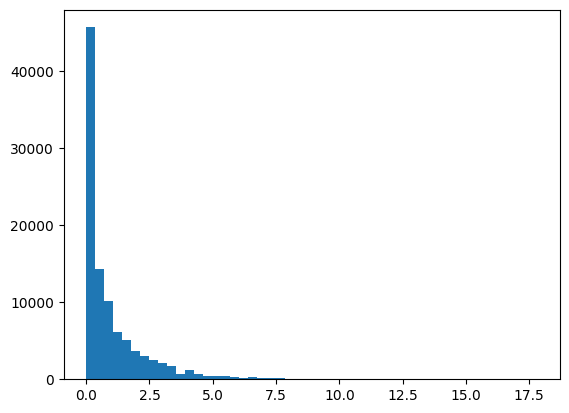

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist = ax.hist(llr_dist, bins=50)

##### Exercise 6.11

Increase `n_points` in the previous cell and rerun to see a smoother $\chi^2$ distribution.

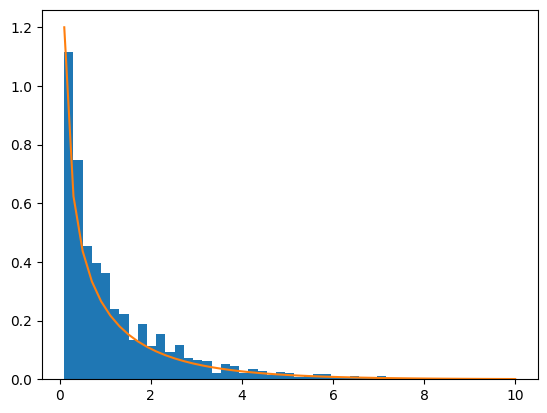

In [655]:
x = np.linspace(0.1, 10)
fig, ax = plt.subplots()
ax.hist(llr_dist, bins=x, density=True)
ax.plot(x, chi2(1).pdf(x))
# print(chi2(1).pdf(x))

The histogram appears to follow the $\chi^2$ distribution correctly.

##### Exercise 6.12

Wilk's theorem states the profile LLR should follow the $\chi^2$ distribution. We use the same rejection criteria as in muon counting example.

In [656]:
l = 3

obsv = np.array([3, 2, 5, 3, 4, 6, 3, 4, 0, 7])
# obsv = poisson.rvs(l,size=10)


LLR = llr(l, obsv)

print(f"This dataset has a log-likelihood profile of {LLR:.3f}")

crit_chi2 = chi2(df=1).ppf(q=0.95)
print(f"The critical chi2 value for 1 dof at 95% CL is: {crit_chi2:.3f}\n")

if LLR < crit_chi2:
    print("The profile LLR falls within the 95% confidence interval")
    print("and the null hypothesis is not excluded at this CL.")
else:
    print("The profile LLR falls outside the 95% confidence interval")
    print("and the null hypothesis is excluded at this CL.")

This dataset has a log-likelihood profile of 1.519
The critical chi2 value for 1 dof at 95% CL is: 3.841

The profile LLR falls within the 95% confidence interval
and the null hypothesis is not excluded at this CL.


### Event Observation

<ErrorbarContainer object of 3 artists>

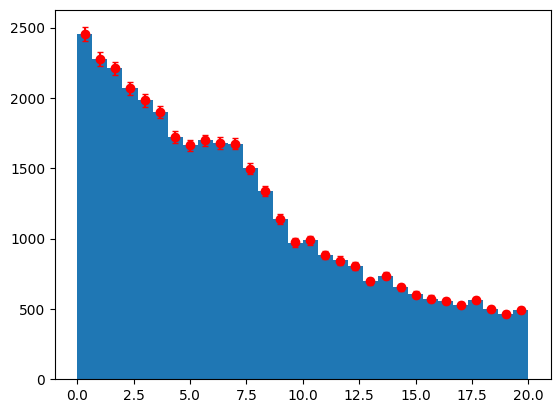

In [658]:
lhc_data = np.genfromtxt("lhc_events_100000.csv", delimiter=",")
entries, edges = np.histogram(lhc_data, bins=30, range=[0, 20])
bin_centres = (edges[:-1] + edges[1:]) / 2

plt.hist(lhc_data, bins=30)
plt.errorbar(bin_centres, entries, yerr=np.sqrt(entries), fmt="o", capsize=2, c="r")

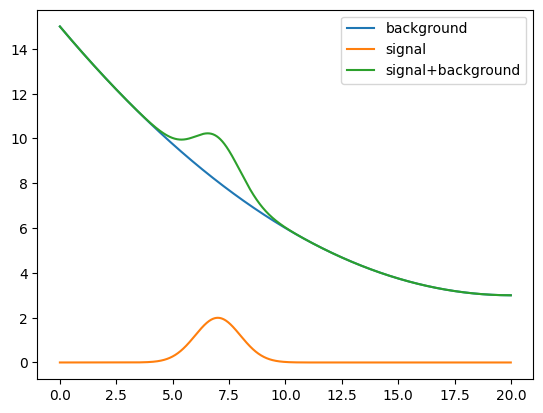

In [659]:
from scipy.stats import norm


def background(myy, A=1):
    a = 15
    b = -1.2
    c = 0.03
    result = A * (c * myy**2 + b * myy + a)
    return result


def signal(myy, B=1):
    mean = 7
    sigma = 1
    result = B * 5 * norm.pdf(myy, mean, sigma)
    return result


x = np.arange(0, 20, 0.01)
plt.plot(x, background(x), label="background")
plt.plot(x, signal(x, 1), label="signal")
plt.plot(x, background(x) + signal(x, 1), label="signal+background")
plt.legend()

In [660]:
import numpy as np
import scipy


def minus_log_lhc_like(params):
    A, B = params
    sum = 0
    entries, edges = np.histogram(lhc_data, bins=30, range=[0, 20])
    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    n = bin_centers.size
    for i in range(0, n):
        # Calcuate the expectation for the signal+background model
        b = background(bin_centers[i], A)
        s = signal(bin_centers[i], B)
        lambda_i = s + b
        k_i = entries[i]
        # scipy.special.gammaln(k_i+1) is a trick to get log(k_i!)
        sum += scipy.stats.poisson.logpmf(k_i, lambda_i)
        # print(k_i,lambda_i,scipy.stats.poisson.logpmf(k_i,lambda_i))
    return -1 * sum

##### Exercise 6.13

In [661]:
import scipy.optimize as opt

x_initial = np.array([50, 50])
results = opt.minimize(minus_log_lhc_like, x_initial, bounds=((160, 170), (160, 170)))

print(f"The resultant parameters are: A = {results.x[0]:.1f}, B = {results.x[1]:.1f}")

max_params = results.x

The resultant parameters are: A = 166.5, B = 163.2


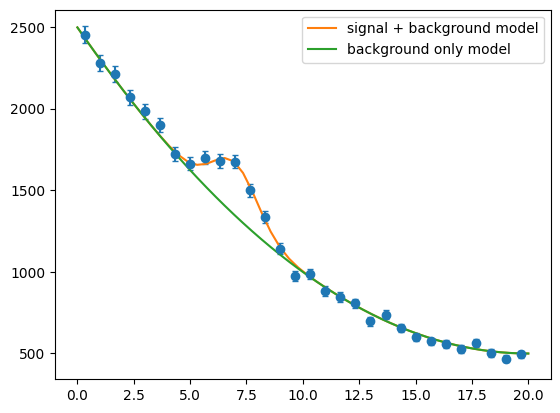

In [ ]:
entries, edges = np.histogram(lhc_data, bins=30, range=[0, 20])
bin_centres = (edges[:-1] + edges[1:]) / 2

x = np.linspace(0, 20)
fig, ax = plt.subplots()
ax.errorbar(bin_centres, entries, yerr=np.sqrt(entries), fmt="o", capsize=2)
ax.plot(
    x,
    background(x, results.x[0]) + signal(x, results.x[1]),
    label="signal + background model",
)
ax.plot(x, background(x, (results.x[0])), label="background only model")
leg = ax.legend()

##### Exercise 6.14

In [664]:
def llr(params, max_params):
    A, B = params
    A_max, B_max = max_params
    sum = 0
    entries, edges = np.histogram(lhc_data, bins=30, range=[0, 20])
    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    n = bin_centers.size
    for i in range(0, n):
        # Calcuate the expectation for the signal+background model
        b = background(bin_centers[i], A)
        s = signal(bin_centers[i], B)
        lambda_i = s + b
        b_max = background(bin_centers[i], A_max)
        s_max = signal(bin_centers[i], B_max)
        lambda_max_i = s_max + b_max
        k_i = entries[i]
        sum += k_i * (np.log(lambda_i) - np.log(lambda_max_i)) - (
            lambda_i - lambda_max_i
        )
    return -2 * sum

In [665]:
LLR = llr((166.5, 0), max_params)
print(f"The value of the profile log likelihood ratio is {LLR:.1f}")

The value of the profile log likelihood ratio is 196.7


##### Exercise 6.15

In [666]:
crit_chi2 = stats.chi2(2).ppf(0.95)
print(f"The critical chi2 value for 2 dof at 95% CL is {crit_chi2:.1f}")

The critical chi2 value for 2 dof at 95% CL is 6.0


The LLR of the null hypothesis is far larger than the critical $\chi^2$ value for 2 degrees of freedom, and so we can certainly exclude the null hypothesis at the 95% confidence level.

To be more correct, we should refit the background only model to allow the background strength to adjust to it's most optimal value

Background only fit:

In [ ]:
def minus_log_lhc_like_background_only(params):
    A = params
    B = 0
    sum = 0
    entries, edges = np.histogram(lhc_data, bins=30, range=[0, 20])
    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    n = bin_centers.size
    for i in range(0, n):
        # Calcuate the expectation for the signal+background model
        b = background(bin_centers[i], A)
        s = signal(bin_centers[i], B)
        lambda_i = s + b
        k_i = entries[i]
        # scipy.special.gammaln(k_i+1) is a trick to get log(k_i!)
        sum += scipy.stats.poisson.logpmf(k_i, lambda_i)
        # print(k_i,lambda_i,scipy.stats.poisson.logpmf(k_i,lambda_i))
    return -1 * sum


x_initial = np.array([50])
results = opt.minimize(
    minus_log_lhc_like_background_only, x_initial, bounds=((160, 170),)
)


LLR_bo = llr((results.x[0], 0), max_params)
print(f"The value of the profile log likelihood ratio is {LLR_bo:.1f}")
crit_chi2 = stats.chi2(1).ppf(0.95)
print(f"The critical chi2 value for 1 dof at 95% CL is {crit_chi2:.1f}")

The value of the profile log likelihood ratio is 161.4
The critical chi2 value for 1 dof at 95% CL is 3.8


This still most certainly does not agree at the 95% confidence level.

##### Exercise 6.16

In [668]:
LLR_new = llr((166.5, 140), max_params)
print(
    f"The value of the profile log likelihood ratio for the new hypothesis is {LLR_new:.1f}"
)

The value of the profile log likelihood ratio for the new hypothesis is 3.5


Comparing this to the critical $\chi^2$ value, this hypothesis can not be excluded at the 95% confidence level.

## Errors on parameters - Not examinable

##### Exercise 6.17

Beginning from our log-likelihood function from before, $$\ln\mathcal{L}(\vec{k};\vec{\theta}) = \sum_i k_i\ln \lambda_i - \lambda_i,$$ $$\frac{\partial}{\partial\theta_j}\ln\mathcal{L}(\vec{k};\vec{\theta}) = \sum_i k_i \frac{\partial}{\partial\theta_j}\ln\lambda_i - \frac{\partial}{\partial\theta_j}\lambda_i$$ $$=\sum_i \left(\frac{k_i}{\lambda_i}  - 1\right)\frac{\partial\lambda_i}{\partial\theta_j}.$$

Differentiating again, 
$$ \frac{\partial^2}{\partial\theta_j\partial\theta_k}\ln\mathcal{L}(\vec{k};\vec{\theta}) = \frac{\partial}{\partial\theta_k}\left(\frac{\partial}{\partial\theta_j}\ln\mathcal{L}(\vec{k};\vec{\theta})\right)$$ 

$$=\sum_i \left[\left(\frac{-k_i}{\lambda_i^2}\frac{\partial \lambda_i}{\partial\theta_k}\right)\frac{\partial\lambda_i}{\partial\theta_j} + \left(\frac{k_i}{\lambda_i}-1\right)\frac{\partial}{\partial\theta_k}\frac{\partial\lambda_i}{\partial\theta_j} \right]$$

$$=\sum_i\left[ \left(\frac{k_i}{\lambda_i}-1\right)\frac{\partial^2\lambda_i}{\partial\theta_j\partial\theta_k} - \frac{\partial\lambda_i}{\partial\theta_j}\frac{\partial\lambda_i}{\partial\theta_k}\frac{k_i}{\lambda_i^2} \right] $$

### Asimov Dataset

From our previous model, 

In [669]:
def lambda_i(params):
    A, B = params
    edges = np.linspace(0, 20, 31, endpoint=True)
    centres = (edges[:-1] + edges[1:]) / 2
    return background(centres, A) + signal(centres, B)

In [670]:
eps = 1
dlambda_dA = (lambda_i(max_params + (eps, 0)) - lambda_i(max_params + (-eps, 0))) / (
    2 * eps
)
dlambda_dB = (lambda_i(max_params + (0, eps)) - lambda_i(max_params + (0, -eps))) / (
    2 * eps
)

In [671]:
dLL_dAA = -np.sum(dlambda_dA * dlambda_dA / lambda_i(max_params))
dLL_dAB = -np.sum(dlambda_dA * dlambda_dB / lambda_i(max_params))
dLL_dBA = -np.sum(dlambda_dB * dlambda_dA / lambda_i(max_params))
dLL_dBB = -np.sum(dlambda_dB * dlambda_dB / lambda_i(max_params))

In [676]:
hessian = -np.array([[dLL_dAA, dLL_dAB], [dLL_dBA, dLL_dBB]])
hess_inv = np.linalg.inv(hessian)
stddev = np.sqrt(hess_inv[1, 1])
print(f"Signal strength error: {stddev:.2f}")

Signal strength error: 13.63


This is the estimated error on our signal strength from the Asimov dataset.

Using the Wald result,

In [673]:
def llr_A(params, hyp):
    A, B = params
    A_hyp, B_hyp = hyp
    sum = 0
    edges = np.linspace(0, 20, 31, endpoint=True)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    n = bin_centers.size
    for i in range(0, n):
        b = background(bin_centers[i], A)
        s = signal(bin_centers[i], B)
        lambda_i = s + b
        b_max = background(bin_centers[i], A_hyp)
        s_max = signal(bin_centers[i], B_hyp)
        lambda_max_i = s_max + b_max
        k_i = lambda_max_i
        sum += k_i * (np.log(lambda_i) - np.log(lambda_max_i)) - (
            lambda_i - lambda_max_i
        )
    return -2 * sum

In [675]:
eps = 10
tA = llr_A(max_params + (0, eps), max_params)
var = (eps**2) / tA
print(f"Signal strength error: {np.sqrt(var):.2f}")

Signal strength error: 12.35
